In [458]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad

In [459]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

We will first try with the usual convex broken power law:

In [460]:
def br_po_lw(xdata, E1, fl_0, lam1, sqrtdelta_lam12):
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return polw

Now let's add the $\chi^2$ to the function in order to minimize:

In [461]:
def br_po_lw_chsq(params): 
    #you need to define theE, SED and SED_u before(E and SED must be a numpy.array and SED an scalar or a numpy.array)
    E1, fl_0, lam1, sqrtdelta_lam12 = params
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return np.sum(np.square(ydata - polw) / np.square(ydata_u))

As we will do a multiple broken power law, from now on the position of the knots will not be a free parameter anymore in order to make the convergence of the fit easier.

In [462]:
def multiple_bpl(xdata, params):
    if knots < 3 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Es = np.geomspace(xdata[0], xdata[-1], knots)
        lam = np.zeros(knots-1)
        phi = np.zeros(knots-1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        lam0 = params[1]
        sqrtdelta_lam = params[2:knots]
        lam[0] = lam0
        phi[0] = phi_0 * ((1/Es[1]) ** (-lam[0]))
        for i in range(1, knots-1):
            lam[i] = lam[i-1] + ((sqrtdelta_lam[i-1]) ** 2)
            phi[i] = phi[i-1] * ((1/Es[i]) ** (-(sqrtdelta_lam[i-1]) ** 2))
        for i in range(knots-1):
            for j in range(len(xdata)):
                if Es[i] < xdata[j] <= Es[i+1]:
                    polw[j] = phi[i] * ((xdata[j]) ** (-lam[i]))
                elif xdata[j] <= Es[1]:
                    polw[j] = phi[0] * ((xdata[j]) ** (-lam[0]))
                elif xdata[j] > Es[-1]:
                    polw[j] = phi[-2] * ((xdata[j]) ** (-lam[-2]))
    return polw


In [463]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

Now we define the function of the fit

In [464]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    #m.tol = 1e-30

    m.migrad()
    #print(m.values)

    m.hesse()
    #print(m.errors)

    return m

Let's check that the program works as intended

In [465]:
file = np.loadtxt('tau_dominguez11.out')

pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)
SED = np.square(E) * dNdEa
SED_u = SED * 0.1

In [466]:
ydata = SED[3:37]
xdata = E[3:37]
knots = 5
ydata_u = SED_u[3:37]
initial_guess = np.array([5e-7, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

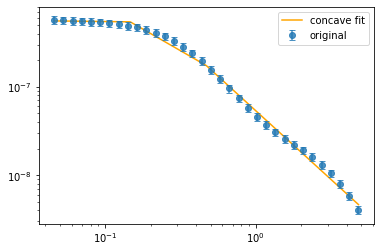

In [467]:
Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Now let's try it with more realistic data. For that, we will copy the data from the Aeff_bkg_spline.ipynb

In [468]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

In [469]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [470]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [471]:
def trapint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation(toplim) + interpolation(bottomlim)) / 2)

def sqint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation((toplim + bottomlim) / 2)))


In [472]:
newBckgrate = np.zeros([len(E[2:37]),2])
for i in range(len(E[2:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+2], Ebinsmax[i+2])
newBckgrate = newBckgrate[:,0]

newlogBckg5 = trapint(Ebinsmax[2:37], Ebinsmin[2:37])

newlogBckg6 = sqint(Ebinsmax[2:37], Ebinsmin[2:37])

In [473]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

In [474]:
EffaA2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+2] and EffaE[j+10] > E[i+2]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+2] + n

In [475]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+2] + n
Angres2 = 10**logAngres2

In [476]:
def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

my_generator = np.random.default_rng(999)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = Simbckg1.astype(float)
# for i in range(len(Simbckg1)):
#     if Simbckg1[i] == 0:
#         Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = Simbckg5.astype(float)
# for i in range(len(Simbckg5)):
#     if Simbckg5[i] == 0:
#         Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)


In [477]:
mu = dNdEa[2:37] * EffaA2 * Ebinsw[2:37] * time 
N = my_generator.poisson(mu)
# N = mu


# for i in range(len(N)):
#     if N[i] == 0:
#         N[i] = mu[i]
N_u = np.sqrt(N)

NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
NpB_u = N_u + Simbckg1_u - Simbckg5_u

print(NpB)

[ 267 1981 2000 2099 2272 2407 2454 2522 2398 2435 2245 1953 1802 1554
 1387 1036  897  641  470  334  277  213  137  108   85   58   46   40
   31   22   19   19    9    9    3]


Now we will add the Energy resolution

In [478]:
fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2

First we need to individualize all the photons from NpB

N before Eres:  [ 267 1981 2000 2099 2272 2407 2454 2522 2398 2435 2245 1953 1802 1554
 1387 1036  897  641  470  334  277  213  137  108   85   58   46   40
   31   22   19   19    9    9    3]
N after Eres:  [1142 1518 1978 2179 2384 2562 2496 2413 2433 2292 1944 1774 1563 1309
 1065  895  674  452  372  276  189  149  111   83   60   50   38   30
   21   21   22    5   10    4]


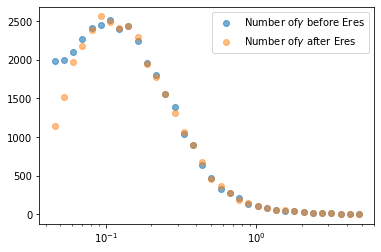

Photons detected before Eres =  34230
Photons detected after Eres =  32514


In [479]:
# NpB
# E[3:37]
# my_generator.normal(E)
# NpB = np.zeros(35).astype(int)
# NpB[8] = 10000


N_ind = []
for i in range(len(NpB)):
    for j in range(NpB[i]):
        N_rand = my_generator.normal(E[2:37][i],Eres2[i]*E[2:37][i])
        N_ind.append(N_rand)


logEbins = np.zeros(len(E[3:37])+1)
for i in range(len(E[3:37])+1):
    if i == 0:
        logEbins[i] = logE[3] - ((logE[4]-logE[3])/2)
    elif i == (len(E[3:37])):
        logEbins[i] = logE[3:37][i-1] + ((logE[3:37][i-1]-logE[3:37][i-2])/2)
    else:
        logEbins[i] = (logE[3:37][i] + logE[3:37][i-1]) / 2

Ebins = 10 ** logEbins


N_hist, E_hist = np.histogram(N_ind, bins = Ebins)
# N_hist, E_hist = np.histogram(N_ind, bins = 100)

print("N before Eres: ", NpB)
print("N after Eres: ",N_hist)

# hist, bins = np.histogram(N_ind, bins=100)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))


plt.scatter(E[3:37], NpB[1:], label = f"Number of$ \gamma$ before Eres", alpha=0.6)
# plt.axvline(x=0.122847, label = "Initial True energy")
plt.scatter(E[3:37], N_hist, label = f"Number of$ \gamma$ after Eres", alpha = 0.5)
plt.xscale("log")
plt.legend()
plt.show()

print("Photons detected before Eres = ", np.sum(NpB))
print("Photons detected after Eres = ", np.sum(N_hist))

In [480]:
E[3:37]

array([0.0457925, 0.0527253, 0.0607077, 0.0698986, 0.0804809, 0.0926653,
       0.106694 , 0.122847 , 0.141446 , 0.16286  , 0.187517 , 0.215906 ,
       0.248593 , 0.286229 , 0.329562 , 0.379457 , 0.436905 , 0.50305  ,
       0.579209 , 0.666899 , 0.767864 , 0.884116 , 1.01797  , 1.17208  ,
       1.34953  , 1.55384  , 1.78909  , 2.05995  , 2.37181  , 2.73089  ,
       3.14434  , 3.62038  , 4.16849  , 4.79958  ])

In [481]:
dNdE_b = N_hist / EffaA2[1:35] / Ebinsw[3:37] / time
dNdE_b_u = (np.sqrt(N_hist) + NpB_u[1:]) / EffaA2[1:35] / Ebinsw[3:37] / time  #idk how to add the previous uncertainties here

In [482]:
SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u

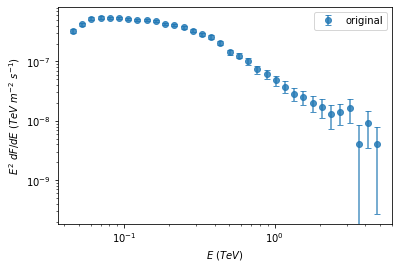

In [483]:
plt.errorbar(E[3:37], SED, label='original',yerr = SED_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

Okay, now let's test the new fitting method:

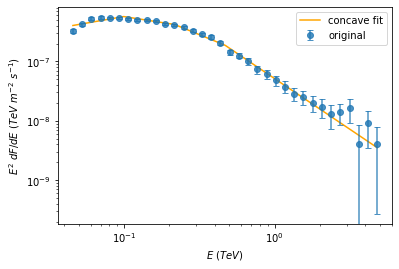

In [484]:
ydata = SED
xdata = E[3:37]
knots = 7
ydata_u = SED_u
initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

alpha =  0.0
alpha =  0.05
alpha =  0.1


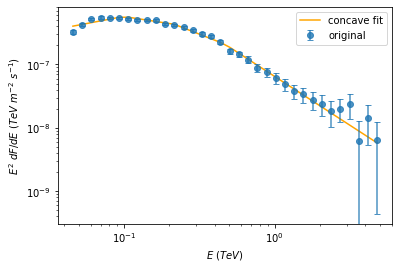

alpha =  0.15


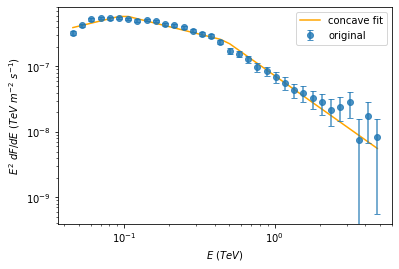

alpha =  0.2
alpha =  0.25
alpha =  0.3
alpha =  0.35
alpha =  0.4
alpha =  0.45
alpha =  0.5
alpha =  0.55
alpha =  0.6
alpha =  0.65
alpha =  0.7
alpha =  0.75
alpha =  0.8
alpha =  0.85
alpha =  0.9


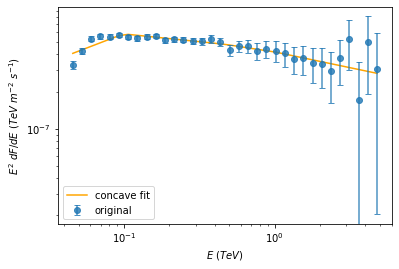

alpha =  0.95
alpha =  1.0


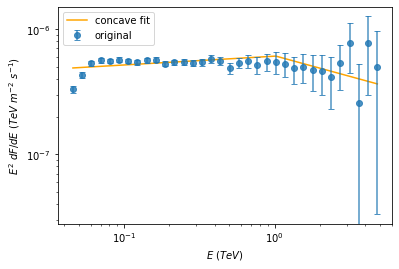

alpha =  1.05
alpha =  1.1
alpha =  1.15
alpha =  1.2
alpha =  1.25
alpha =  1.3
alpha =  1.35
alpha =  1.4
alpha =  1.45
alpha =  1.5
alpha =  1.55
alpha =  1.6
alpha =  1.65
alpha =  1.7
alpha =  1.75
alpha =  1.8
alpha =  1.85
alpha =  1.9
alpha =  1.95
alpha =  2.0


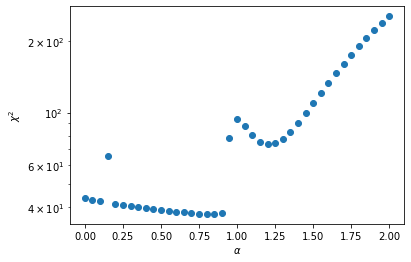

In [485]:
chisqs = []
alphas = []

for i in range(41):
    alpha = round(0.05 * i, 2)
    print("alpha = ", alpha)
    alphas.append(alpha)
    dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
    dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
    SED2 = np.square(E[3:37]) * dNdE2
    SED_u2 = np.square(E[3:37]) * dNdE2_u
    ydata = SED2
    xdata = E[3:37]
    knots = 7
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
    chisqs.append(chi2)

    if alpha == 0.1 or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
        plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
        plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r"$E$ ($TeV$)")
        plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        plt.legend()
        plt.show()

plt.plot(alphas, chisqs, 'o')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

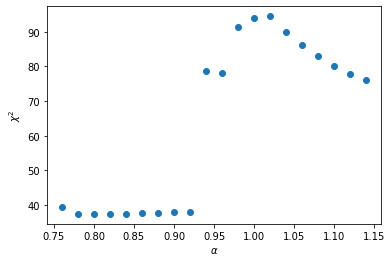

In [486]:
chisqs = []
alphas = []

for i in range(20):
    alpha = round(0.76 + 0.02 * i, 2)
    alphas.append(alpha)
    dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
    dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
    SED2 = np.square(E[3:37]) * dNdE2
    SED_u2 = np.square(E[3:37]) * dNdE2_u
    ydata = SED2
    xdata = E[3:37]
    knots = 7
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
    chisqs.append(chi2)

plt.plot(alphas, chisqs, 'o')
#plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

Now checking consistency with MAGIC Aeff and bckg

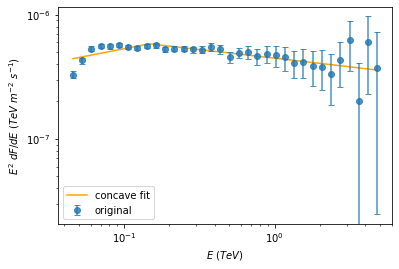

In [487]:
alpha = 0.94
dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
SED2 = np.square(E[3:37]) * dNdE2
SED_u2 = np.square(E[3:37]) * dNdE2_u
ydata = SED2
xdata = E[3:37]
knots = 5
ydata_u = SED_u2
initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()